# Transfer Attack

In [454]:
!pip install ultralytics &> /dev/null

In [455]:
from ultralytics import YOLO
import numpy as np
from PIL import Image
import requests
from io import BytesIO
import cv2
import matplotlib.pyplot as plt
import torch
import torchvision

from torchvision import transforms
ConvertTensor=transforms.ToTensor()

DEVICE = torch.device('cuda')

In [456]:
def box_label(image, box, label='', color=(128, 128, 128), txt_color=(255, 255, 255)):
  lw = max(round(sum(image.shape) / 2 * 0.003), 2)
  p1, p2 = (int(box[0]), int(box[1])), (int(box[2]), int(box[3]))
  cv2.rectangle(image, p1, p2, color, thickness=lw, lineType=cv2.LINE_AA)
  if label:
    tf = max(lw - 1, 1)  # font thickness
    w, h = cv2.getTextSize(label, 0, fontScale=lw / 3, thickness=tf)[0]  # text width, height
    outside = p1[1] - h >= 3
    p2 = p1[0] + w, p1[1] - h - 3 if outside else p1[1] + h + 3
    cv2.rectangle(image, p1, p2, color, -1, cv2.LINE_AA)  # filled
    cv2.putText(image,
                label, (p1[0], p1[1] - 2 if outside else p1[1] + h + 2),
                0,
                lw / 3,
                txt_color,
                thickness=tf,
                lineType=cv2.LINE_AA)

In [457]:
def plot_bboxes(image, boxes, labels=[], colors=[], score=True, conf=None):
  #Define Labels
  if labels == []:
    labels = {0: u'Cyclist', 1: u'DontCare', 2: u'Misc', 3: u'Person_sitting', 4: u'Tram', 5: u'Truck', 6: 'Van', 7: u'car', 8: u'person'}
  #Define colors
  if colors == []:
    #colors = [(6, 112, 83), (253, 246, 160), (40, 132, 70), (205, 97, 162), (149, 196, 30), (106, 19, 161), (127, 175, 225), (115, 133, 176), (83, 156, 8), (182, 29, 77), (180, 11, 251), (31, 12, 123), (23, 6, 115), (167, 34, 31), (176, 216, 69), (110, 229, 222), (72, 183, 159), (90, 168, 209), (195, 4, 209), (135, 236, 21), (62, 209, 199), (87, 1, 70), (75, 40, 168), (121, 90, 126), (11, 86, 86), (40, 218, 53), (234, 76, 20), (129, 174, 192), (13, 18, 254), (45, 183, 149), (77, 234, 120), (182, 83, 207), (172, 138, 252), (201, 7, 159), (147, 240, 17), (134, 19, 233), (202, 61, 206), (177, 253, 26), (10, 139, 17), (130, 148, 106), (174, 197, 128), (106, 59, 168), (124, 180, 83), (78, 169, 4), (26, 79, 176), (185, 149, 150), (165, 253, 206), (220, 87, 0), (72, 22, 226), (64, 174, 4), (245, 131, 96), (35, 217, 142), (89, 86, 32), (80, 56, 196), (222, 136, 159), (145, 6, 219), (143, 132, 162), (175, 97, 221), (72, 3, 79), (196, 184, 237), (18, 210, 116), (8, 185, 81), (99, 181, 254), (9, 127, 123), (140, 94, 215), (39, 229, 121), (230, 51, 96), (84, 225, 33), (218, 202, 139), (129, 223, 182), (167, 46, 157), (15, 252, 5), (128, 103, 203), (197, 223, 199), (19, 238, 181), (64, 142, 167), (12, 203, 242), (69, 21, 41), (177, 184, 2), (35, 97, 56), (241, 22, 161)]
    colors = [(89, 161, 197),(67, 161, 255),(19, 222, 24),(186, 55, 2),(167, 146, 11),(190, 76, 98),(130, 172, 179),(115, 209, 128),(204, 79, 135),(136, 126, 185),(209, 213, 45),(44, 52, 10),(101, 158, 121),(179, 124, 12),(25, 33, 189),(45, 115, 11),(73, 197, 184),(62, 225, 221),(32, 46, 52),(20, 165, 16),(54, 15, 57),(12, 150, 9),(10, 46, 99),(94, 89, 46),(48, 37, 106),(42, 10, 96),(7, 164, 128),(98, 213, 120),(40, 5, 219),(54, 25, 150),(251, 74, 172),(0, 236, 196),(21, 104, 190),(226, 74, 232),(120, 67, 25),(191, 106, 197),(8, 15, 134),(21, 2, 1),(142, 63, 109),(133, 148, 146),(187, 77, 253),(155, 22, 122),(218, 130, 77),(164, 102, 79),(43, 152, 125),(185, 124, 151),(95, 159, 238),(128, 89, 85),(228, 6, 60),(6, 41, 210),(11, 1, 133),(30, 96, 58),(230, 136, 109),(126, 45, 174),(164, 63, 165),(32, 111, 29),(232, 40, 70),(55, 31, 198),(148, 211, 129),(10, 186, 211),(181, 201, 94),(55, 35, 92),(129, 140, 233),(70, 250, 116),(61, 209, 152),(216, 21, 138),(100, 0, 176),(3, 42, 70),(151, 13, 44),(216, 102, 88),(125, 216, 93),(171, 236, 47),(253, 127, 103),(205, 137, 244),(193, 137, 224),(36, 152, 214),(17, 50, 238),(154, 165, 67),(114, 129, 60),(119, 24, 48),(73, 8, 110)]
  
  #plot each boxes
  for box in boxes:
    #add score in label if score=True
    if score :
      label = labels[int(box[-1])] + " " + str(round(100 * float(box[-2]),1)) + "%"
    else :
      label = labels[int(box[-1])]
    #filter every box under conf threshold if conf threshold setted
    if conf :
      if box[-2] > conf:
        color = colors[int(box[-1])]
        box_label(image, box, label, color)
    else:
      color = colors[int(box[-1])]
      box_label(image, box, label, color)

  #show image
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  plt.figure(figsize=(15,15))
  plt.axis("off")
  plt.imshow(image.astype(np.uint8), interpolation="nearest")

In [458]:
input_img = Image.open("/home/aya/Desktop/Kitti_YOLOv8/datasets/test/images/005061.png")
input_img = np.asarray(input_img)
input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)  # Convert to RGB

In [459]:
model=YOLO("../best.pt")
results = model.predict(input_img)

Ultralytics YOLOv8.0.20 🚀 Python-3.10.6 torch-1.12.0+cu102 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11169MiB)
Model summary (fused): 168 layers, 3008573 parameters, 0 gradients, 8.1 GFLOPs


In [460]:
KITTI_INSTANCE_CATEGORY_NAMES = {0: u'Cyclist', 1: u'DontCare', 2: u'Misc', 3: u'Person_sitting', 4: u'Tram', 5: u'Truck', 6: 'Van', 7: u'car', 8: u'person'}

In [461]:
results[0].boxes.boxes

tensor([[0.00000e+00, 0.00000e+00, 4.40000e+02, 3.74000e+02, 9.32335e-01, 6.00000e+00],
        [7.21000e+02, 1.60000e+02, 1.08400e+03, 3.09000e+02, 9.29153e-01, 7.00000e+00],
        [3.84000e+02, 1.40000e+02, 5.47000e+02, 2.78000e+02, 9.22533e-01, 6.00000e+00],
        [6.62000e+02, 1.73000e+02, 7.18000e+02, 2.20000e+02, 8.50202e-01, 7.00000e+00],
        [6.45000e+02, 1.72000e+02, 6.95000e+02, 2.14000e+02, 7.36814e-01, 7.00000e+00],
        [5.51000e+02, 1.69000e+02, 5.73000e+02, 1.89000e+02, 6.12969e-01, 7.00000e+00],
        [5.95000e+02, 1.67000e+02, 6.14000e+02, 1.86000e+02, 5.91286e-01, 7.00000e+00]], device='cuda:0')

In [462]:
results[0].boxes.conf

tensor([0.93234, 0.92915, 0.92253, 0.85020, 0.73681, 0.61297, 0.59129], device='cuda:0')

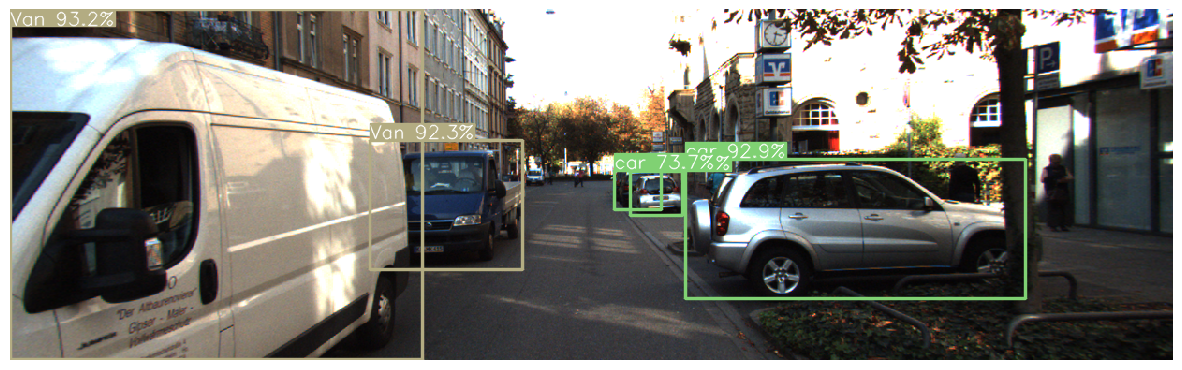

In [463]:
img=input_img.copy()
plot_bboxes(img, results[0].boxes.boxes, conf=0.7)

## Generate an attack

In [464]:
from art.attacks.evasion import DPatch
from art.estimators.object_detection import PyTorchFasterRCNN

In [465]:
# Create ART object detector
frcnn = PyTorchFasterRCNN(
        clip_values=(0, 255), attack_losses=["loss_classifier", "loss_box_reg", "loss_objectness", "loss_rpn_box_reg"],device_type="gpu"
    )

/home/aya/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/aya/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/aya/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and will be removed in 0.15, please use 'weights_backbone' instead.
  warnings.warn(
/home/aya/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other tha

In [466]:
img = cv2.resize(input_img, dsize=(input_img.shape[1], input_img.shape[0]), interpolation=cv2.INTER_CUBIC)
image = np.stack([input_img], axis=0).astype(np.float32)
print("image.shape:", image.shape)

image.shape: (1, 375, 1242, 3)


In [467]:
def get_loss(frcnn, x, y):
    frcnn._model.train()
    transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
    image_tensor_list = list()

    for i in range(x.shape[0]):
        if frcnn.clip_values is not None:
            img = transform(x[i] / frcnn.clip_values[1]).to(frcnn._device)
        else:
            img = transform(x[i]).to(frcnn._device)
        image_tensor_list.append(img)

    loss = frcnn._model(image_tensor_list, y)
    for loss_type in ["loss_classifier", "loss_box_reg", "loss_objectness", "loss_rpn_box_reg"]:
        loss[loss_type] = loss[loss_type].cpu().detach().numpy().item()
    return loss


def append_loss_history(loss_history, output):
    for loss in ["loss_classifier", "loss_box_reg", "loss_objectness", "loss_rpn_box_reg"]:
        loss_history[loss] += [output[loss]]
    return loss_history

In [468]:
# Define attack parameters
# patch_shape = (68, 68,3)  # Adjust the patch shape as needed
patch_shape = (78, 78,3)  # Adjust the patch shape as needed
patch_location = (182, 82)  # Adjust the patch location as needed
crop_range = (0, 0)  # Adjust the crop range as needed
max_iter=2000 #The number of optimization steps

attack = DPatch(
        frcnn,
        patch_shape=patch_shape,
        learning_rate=2.5,
        max_iter=2,
        batch_size=16,
        verbose=False
        
    )

In [469]:
y = frcnn.predict(x=image) # here y is a dict

# Convert target boxes to Tensor
for i, y_i in enumerate(y):
        y[i]["boxes"] = torch.from_numpy(y_i["boxes"]).type(torch.float).to(frcnn._device)
        y[i]["labels"] = torch.from_numpy(y_i["labels"]).type(torch.int64).to(frcnn._device)
        y[i]["scores"] = torch.from_numpy(y_i["scores"]).to(frcnn._device)

In [470]:
#define a targated label
y_target=[{'boxes':np.asarray([[683.18,166,809,250]],dtype=np.float32),'labels':np.asarray([3]),'scores':np.asarray([0.3])}]

In [478]:
loss_history = {"loss_classifier": [], "loss_box_reg": [], "loss_objectness": [], "loss_rpn_box_reg": []}


for i in range(max_iter):
        print("Iteration:", i)
        patch = attack.generate(x=image,target_label=0)
        x_patch = attack.apply_patch(x=image,random_location=True)
        loss = get_loss(frcnn, x_patch,y)
        print(loss)
        loss_history = append_loss_history(loss_history, loss)

# x = image.copy()
# y = frcnn.predict(x=x, standardise_output=False)

# history = []
# total_history = []
# for i in range(50):
#     print("Iteration:", i)
#     patch = attack.generate(x=x)
#     x_patch = attack.apply_patch(x.copy())

#     loss = frcnn.compute_loss(x_patch, y)[0]
#     total_history.append(loss)
#     print('Total loss:', loss)
#     losses = frcnn.compute_losses(x_patch, y)
#     history.append(losses)
#     print('Losses:', losses)
#     print('------')

Iteration: 0


IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

In [472]:
print("The resulting maximal difference in pixel values is {}.".format(np.amax(np.abs(img - x_patch))))

The resulting maximal difference in pixel values is 255.0.


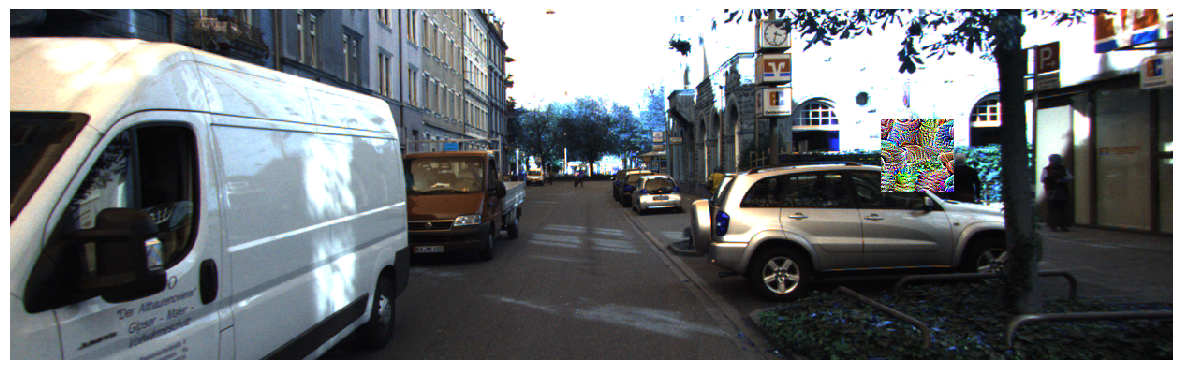

In [473]:
plt.figure(figsize=(15,15))
plt.axis("off")
plt.imshow(x_patch[0].astype(np.uint8), interpolation="nearest")

In [474]:
# save the image
img_save = cv2.cvtColor(x_patch[0], cv2.COLOR_BGR2RGB)
cv2.imwrite("photo.png", img_save)

True

In [475]:
img=Image.open("photo.png")
img = np.asarray(img)
#predict
results = model.predict(img)

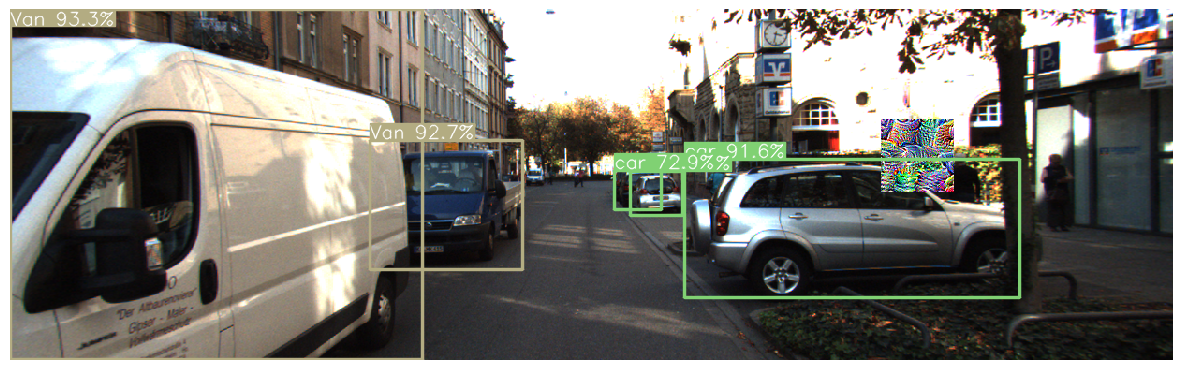

In [476]:
#read the image in cv2
im=cv2.imread("photo.png")
# Convert to RGB
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
#Draw bboxes
plot_bboxes(img, results[0].boxes.boxes, conf=0.7)